## DSBD Project 2 -- LendingClub Peer-to-Peer Lending Prediction
### Intermediate Report

#### Yunhan (Claire) Xu, Qiyang (Cathy) Chen

Starting from 2015, the idea of Peer-to-Peer (P2P) lending emerged, which allows individuals (borrowers) to obtain loans directly from other individuals (investors) through platforms such as LendingClub, Prosper, and Upstart. This kind of "social lending" becomes an alternative financing approach, cutting out the financial institution as the middleman. P2P lending enables investors to acquire a higher return on investment compared to a bank deposit. However, credit risk, one of the biggest concerns for investors, emerges when they make informed investment decisions within the P2P lending procedure. In particular, a default due to failing to make the required payment within the agreed date for a borrower would induce a loss for an investor. 

In this project, we plan to develop a model that will predict whether a LendingClub-approved loan will end up being defaulted or not. The collected dataset includes loan grade, indicating the credit risk from the credit report and loan application. We plan to set the loan grade as the baseline and compare it with our model performance. 

The domain of our project is as follows:
- Task (T) - Classification task that predicts defaulted loan 
- Performance Measure (P) 
    - Recall: among all the actually defaulted loans, how many of them did we successfully identified
    - Precision: among all the loans that we predicted as default loans, how many of them actually defaulted
- Experience (E) - LendingClub database of loan records with loan status that we can use to label a loan as defaulted or not
<!-- machine-learned classification models (SVM, logistic regression, decision trees, random forests, XGBoost, etc.) -->

In sum, considering a classification task of identifying loans that are likely to default, we will train the LendingClub database of loan records without the pre-specified loan grades to perform the task and utilize precision, recall, and F-1 score as performance metrics to measure how well we complete the task.  

## 1. Data

The original data contains all the LendingClub loan data from 2007 to 2018, and the corresponding 151 features are related to borrowers' credit history and loan characteristics. We performed some basic data cleaning beforehand:
- For the scoping purpose, we only focus on data from the latest four years, i.e., 2015-2018. 
- There are seven loan statuses: Charged Off, Current, Default, Fully Paid, In Grace Period, Late (16-30 days), Late (31-120 days). As we don't know whether a "Current" loan would be defaulted or not, we disregard those loans. We consider Late (16-30 days), Late (31-120 days), Default, and Charged Off as a Defaulted loan and Fully Paid as a desirable loan.

### Columns we discarded
- 100% missing values: `id`, `member_id`, `url`, `next_pymnt_d`
- The same for all rows: `pymnt_plan`, `out_prncp`, `out_prncp_inv`, and `policy_code`
- Updated in past 2 months -- wouldn't have these values at loan origination: `num_tl_120dpd_2m`, `num_tl_30dpd`, `last_fico_range_low`, and
`last_fico_range_high`
- Hardship-related variables, relating to borrowers who were on a hardship plan -- wouldn't know at the point of loan origination whether or not the borrower will have a hardship: `deferral_term`, `hardship_amount`, `hardship_dpd`, `hardship_end_date`, `hardship_flag`, `hardship_last_payment_amount`, `hardship_length`, `hardship_loan_status`, `hardship_payoff_balance_amount`, `hardship_reason`, `hardship_start_date`, `hardship_status`, `hardship_type`, `orig_projected_additional_accrued_interest`, `payment_plan_start_date`
- String variables provided by borrowers. LendingClub categorized them into other variables: `desc`, `title`, and `emp_title`
- Loan settlement/charged off related variables -- wouldn't know them at the time of funding: `debt_settlement_flag`, `debt_settlement_flag_date`, `settlement_amount`, `settlement_date`, `settlement_percentage`, `settlement_status`, `settlement_term`, `recoveries`, `collection_recovery_fee`
- Loan payment related variables -- wouldn't know them at the time of funding: `funded_amnt`, `funded_amnt_inv`, `last_pymnt_amnt`, `out_prncp`, `out_prncp_inv`, `total_pymnt`, `total_pymnt_inv`, `total_rec_int`, `total_rec_late_fee`, `total_rec_prncp`, `last_pymnt_d`, `last_credit_pull_d`, `disbursement_method`
- `initial_list_status`: as the values "W' and "F" are randomly assigned
- Columns relating to co-borrowers. These columns only have non-null values from issue dates of 2017-03-01 and later (or 2015-10-01 and later for 'dti_joint', 'annual_inc_joint', and 'verification_status_joint'), and have around 97% missing values, so we remove these columns: `annual_inc_joint`, `dti_joint`, `revol_bal_joint`, `sec_app_chargeoff_within_12_mths`, `sec_app_collections_12_mths_ex_med`, `sec_app_earliest_cr_line`, `sec_app_inq_last_6mths`, `sec_app_mort_acc`, `sec_app_mths_since_last_major_derog`, `sec_app_num_rev_accts`, `sec_app_open_acc`, `sec_app_open_act_il`, `sec_app_revol_util`, `verification_status_joint`, `sec_app_fico_range_low`, `sec_app_fico_range_high`
- Other: `zip_code`

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [ ]:
import matplotlib
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
sns.set(font_scale=1.5)
sns.set_style('ticks')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DSBD Project_2 ML/LC_15_18.csv').iloc[:, 1:]

## 2. Data Cleaning

In [ ]:
# drop additional colmns
data = data.drop(['last_fico_range_low', 'last_fico_range_high'], axis = 1)

In [ ]:
# check number of rows and cols in the dataset
data.shape

(927931, 71)

In [ ]:
# change data type
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

In [ ]:
# check missing values in the dataset
def missing_values_table(data):
    '''
    generate a table that contains attributes and its corresponing number of missing values 
    and percentage of missing value
    '''
    #Number of null values by column
    mv_df = pd.DataFrame(data.isna().sum(),columns=['Count_Missing'])
    
    #Portion of null values by column
    mv_df['Pctg_Missing'] = mv_df['Count_Missing']/len(data)

    #Sort by Missing_Count
    mv_df = mv_df.sort_values('Count_Missing',ascending=False)  
    
    return mv_df

mv_df = missing_values_table(data)

mv_df.head()

,Count_Missing,Pctg_Missing
mths_since_last_record,753505,0.812027
mths_since_recent_bc_dlq,696123,0.750188
mths_since_last_major_derog,659938,0.711193
mths_since_recent_revol_delinq,600515,0.647155
mths_since_last_delinq,451425,0.486486


In [ ]:
# Re-categorize emp_length into 4 categories
def process_emp_len(d):
    '''
    re_categorize the employment length in years to reduce the categories
    '''
    df = d.copy()
    # 0-1 years include null, < 1 year and 1 year
    df['emp_length'] = df['emp_length'].fillna('0-1 years')
    df['emp_length'] = np.where(df['emp_length'].isin([np.nan,None,'< 1 year','1 year']),'0-1 years',df['emp_length'])

    # 2-5 years include 2 years, 3 years, 4 years and 5 years
    df['emp_length'] = np.where(df['emp_length'].isin(['2 years','3 years','4 years', '5 years']),'2-5 years',df['emp_length'])

    # 6-9 years include 6 years, 7 years, 8 years and 9 years
    df['emp_length'] = np.where(df['emp_length'].isin(['6 years','7 years','8 years', '9 years']),'6-9 years',df['emp_length'])

    return df


# For missing values in columns that measure "months since": fill the nulls with maximum observed value +1
def process_month_since_cols(d):
    '''
    fill the null values with the maximum observed value + 1 in 'month since' related columns, 
    the borrowers who have never had delinquencies will have the largest value for number of months 
    since delinquency.
    '''
    df = d.copy()

    mon_since_cols = ['mo_sin_old_il_acct','mths_since_last_delinq','mths_since_last_major_derog',
                     'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq',
                     'mths_since_recent_revol_delinq','mo_sin_old_rev_tl_op','mths_since_recent_bc',
                     'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']

    for i in mon_since_cols:
        df[i].fillna(df[i].max()+1, inplace=True)
    
    return df


# Change grade and sub_grade to numerical rankings (the lower the number, the less risky the loan)
def process_loan_grades(d):
    '''
    turn loan grade and sub_grade into ordinal mapping
    '''
    df = d.copy()

    # turn grade into ordinal mapping
    sorted_grades = sorted(d.grade.unique())
    grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
    df['grade'] = df['grade'].map(grade_dict)

    # turn sub_grade into ordinal mapping
    sorted_subgrades = sorted(d.sub_grade.unique())
    subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
    df['sub_grade'] = df['sub_grade'].map(subgrade_dict)

    return df


# Process the above transformation and a few more transformations
def process_loan_cols(d):
    """
    process the data to obtain a cleaner dataset
    """
    df_processed = process_emp_len(d)
    df_processed = process_month_since_cols(df_processed)
    df_processed = process_loan_grades(df_processed)
    
    # add `credit_line_length` by compute the difference between the month the borrower's earliest reported credit line was opened
    # and the month which the loan was funded. Then discard the earliest_cr_line column.
    df_processed['credit_line_length'] = df_processed['issue_d'] - df_processed['earliest_cr_line']
    df_processed = df_processed.drop(['earliest_cr_line'], axis=1)

    # process `revol_util`, `int_rate`, `credit_line_length`
    df_processed['revol_util'] = df_processed['revol_util'].apply(lambda x: x/100)
    df_processed['int_rate'] = df_processed['int_rate'].apply(lambda x: x/100)
    df_processed['credit_line_length'] = df_processed['credit_line_length'].apply(lambda x: x.days)
    
    # generate `default` (binary variable, 0 means not defaulted, 1 means defaulted) and drop `loan_status`
    df_processed['default'] = df_processed['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1, 'Default': 1,
                                                                  'In Grace Period': 1, 'Late (16-30 days)': 1, 
                                                                  'Late (31-120 days)': 1})
    df_processed = df_processed.drop(columns='loan_status')
    
    return df_processed


In [ ]:
# create a new pre-process dataset
data_new = process_loan_cols(data)

In [ ]:
# check missing values in new dataset
mv_df = missing_values_table(data_new) # the greatest missing percentage of a feature is around 0.01

# get the list of variables that have missing values
mv_list = mv_df[mv_df['Count_Missing'] > 0].index.tolist() # all the variables that have missing values are float

# impute these missing values with its median
for var in mv_list:
    data_new[var] = data_new[var].fillna((data_new[var].median()))

In [ ]:
# check the data type for each attribute
types_data = pd.DataFrame(data_new.dtypes, columns=['Types'])

# check the categorical data
cat_var = types_data[types_data['Types'] == 'object'].index.tolist()
cat_var

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'application_type',
 'issue_month']

In [ ]:
# create dummy variables for categorical variables
data_new = pd.get_dummies(data_new, columns=cat_var, drop_first=True) 

In [ ]:
# check the data type for each attribute
types_data = pd.DataFrame(data_new.dtypes, columns=['Types'])

# change the data type of dummies to float
uint_var = types_data[types_data['Types'] == 'uint8'].index.tolist()
data_new[uint_var] = data_new[uint_var].astype(np.float64)


## 3. Exploratory Data Analysis

In [ ]:
data_new.groupby('default')['default'].count()/len(data_new)

default
0    0.756728
1    0.243272
Name: default, dtype: float64

75.67% of the loans are fully paid while 24.32% of the loans are defaulted.

### Loan Amount distribution by the loan grade

[Text(0, 0.5, 'Average loan amount in dollars'),
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6')],
 Text(0.5, 0, 'Loan grade (higher value refers to a higher risk)')]

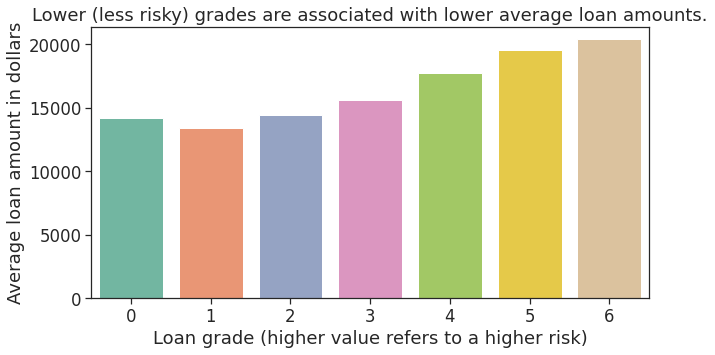

In [ ]:
#Loan amount by grade
group_loan = data_new.groupby('grade').mean()
avg_loan = group_loan['loan_amnt'].reset_index()
xticklabels = avg_loan.index.tolist()

plt.subplots(figsize=(10,5))
plt.title('Lower (less risky) grades are associated with lower average loan amounts.')
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2'
           ).set(xlabel='Loan grade (higher value refers to a higher risk)', ylabel='Average loan amount in dollars',
                 xticklabels=xticklabels)

# group_loan = data_new.groupby('grade').mean()
# avg_loan = group_loan['loan_amnt'].reset_index()

# alt.Chart(avg_loan, title = 'Lower (less risky) grades are associated with lower average loan amounts.').mark_bar().encode(
#     alt.X('grade:N', title = 'Loan grade (higher value refers to a higher risk)'),
#     alt.Y('loan_amnt:Q', title = 'Average loan amount in dollars'),
#     color = 'grade:N'
# ).properties(width = 500, height = 400)

### Default and fully paid loan distribution Date of Loan Issuance

In [ ]:
#Default and fully paid loan count by Date of Loan Issuance
count_loan = data_new.groupby(['default', 'issue_d']).size()
count_loan = count_loan.reset_index().rename(columns = {0: 'count'})
count_loan['issue_d'] = count_loan['issue_d'].dt.strftime('%Y-%m')

# alt.Chart(count_loan, 
#     title = 'Number of loan amount had a spike in March, 2016 for both default and fully paid loan, but it started to decline since then.')\
#     .mark_area().encode(
#     alt.X('issue_d:N', title = 'Loan issue date'),
#     alt.Y('count:Q', title = 'Number of loan amount'),
#     color = 'default:N'
#     # tooltip = ['issue_d:N', 'count:Q']
# ).properties(width = 500, height = 400)

fig = px.area(count_loan, 
              x="issue_d", y="count", color="default",
              title = 'Number of loan had a spike in March, 2016 for both default and fully paid loan, but it started to decline since then.',
              labels = {'x':'Loan issue date', 
              'y':'Number of loan amount'})
fig.show()

### Feature Importances

Since there are more than 100 variables, we would like to first get a sense of which features are the most predictive by training a simple Random Forest Classifier and looking at the feature importance plot.

In [ ]:
# When training the model, we need to first discard some columns:
# 'issue_d' has the date data type, which cannot be used in the rf model
# 'grade', 'sub_grade', and 'int_rate' are determined by loans' and borrowers' features and are directly associated with default risk
rf_data = data_new.drop(columns= ['issue_d', 'grade', 'sub_grade', 'int_rate'])
data_train, data_val = train_test_split(rf_data, test_size=.1, stratify=rf_data['default'], random_state=1998)

X_train = data_train.drop(columns='default')
y_train = data_train['default']

X_val = data_val.drop(columns='default')
y_val = data_val['default']

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None).fit(X_train, y_train)

importances = pd.DataFrame({'Columns':X_train.columns,'Feature_Importances':rf_model.feature_importances_})
importances = importances.sort_values(by='Feature_Importances',ascending=False)

In [ ]:
importances.head(15)

,Columns,Feature_Importances
3,dti,0.031057
1,installment,0.030798
58,term_ 60 months,0.027209
23,bc_open_to_buy,0.025691
28,mo_sin_old_rev_tl_op,0.025224
52,tot_hi_cred_lim,0.024930
22,avg_cur_bal,0.024861
2,annual_inc,0.024729
0,loan_amnt,0.024654
57,credit_line_length,0.024188


The 15 most important predictors are:
- `dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- `installment`: The monthly payment owed by the borrower if the loan originates.
- `term`: The number of payments on the loan. Values are in months and can be either 36 or 60.
- `bc_open_to_buy`: Total open to buy on revolving bankcards.
- `loan_amnt`
- `mo_sin_old_rev_tl_op`: Months since oldest revolving account opened.
- `tot_hi_cred_lim`: Total high credit/credit limit.
- `avg_cur_bal`: Average current balance of all accounts.
- `annual_inc`: The self-reported annual income provided by the borrower during registration.
- `total_rev_hi_lim`: Total revolving high credit/credit limit.
- `credit_line_length`: The difference between the month the borrower's earliest reported credit line was opened and the month which the loan was funded.
- `total_bc_limit`: Total bankcard high credit/credit limit.
- `bc_util`: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
- `mo_sin_old_il_acct`: Months since oldest bank installment account opened
- `revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

Let's do some EDA on these 15 predictors.

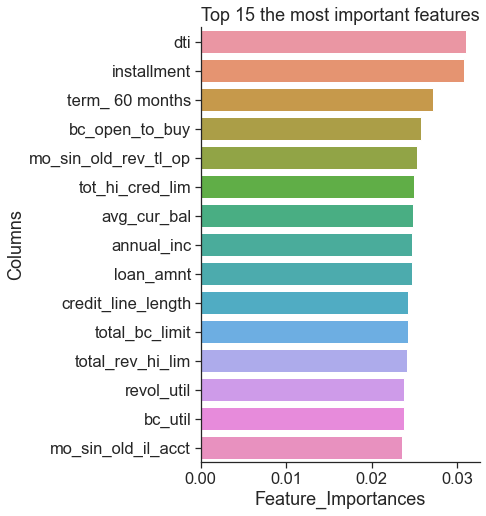

In [ ]:
# Generate a bar graph of the top 15 the most important features selected by Random Forest
fig, ax = plt.subplots(figsize=(5,8))
plt.title('Top 15 the most important features')
ax = sns.barplot(x=importances['Feature_Importances'].head(15), y=importances['Columns'].head(15))
sns.despine()

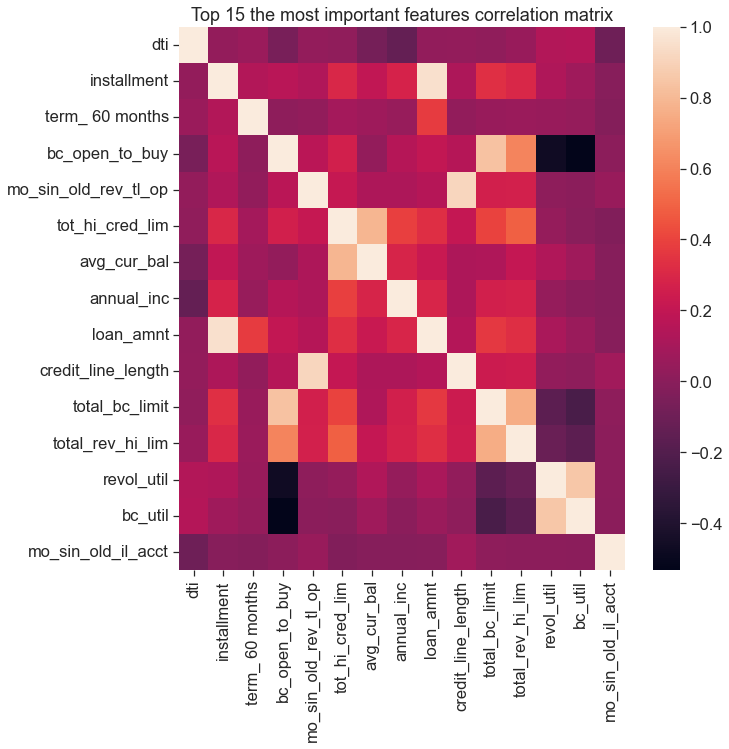

In [ ]:
# Generate correlation matrix
ele = importances['Columns'][:15]
imp_corr = data_new[ele]
corrMatrix = imp_corr.corr()
plt.subplots(figsize=(10,10))
plt.title('Top 15 the most important features correlation matrix')
sns.heatmap(corrMatrix, annot=False)
plt.show()

By looking at the correlation among top 15 the most important features, we find the features have high correlation as follows:

1. Monthly payment owed by the borrower if the loan originates has a high correlation with loan amount.
2. Months since oldest revolving account opened has a high correlation with the difference between the month the borrower's earliest reported credit line was opened and the month which the loan was funded.
3. Ratio of total current balance to high credit/credit limit for all bankcard accounts has a high correlation with the amount of credit the borrower is using relative to all available revolving credit.


In [ ]:
# Predictors related to loans
data_new.groupby('default').agg({
                'term_ 60 months': 'mean',
                'installment': 'median',
                'loan_amnt': 'median'
})

,term_ 60 months,installment,loan_amnt
default,,,
0,0.194299,364.70,12000.0
1,0.382887,408.22,14725.0


`term` is the number of payments on the loan. Values are in months and can be either 36 or 60. 38.29% of the defaulted loans are 60-months while only 19.43% of the fully paid loans are 60-months. 

Defaulted loans have a higher monthly payment owed by the borrower if the loan originates and a higher loan amount.

In [ ]:
# Predictors related to borrowers' financials
data_new.groupby('default').agg({
    'dti': 'median',
    'bc_open_to_buy': 'median',
    'mo_sin_old_rev_tl_op': 'median',
    'tot_hi_cred_lim': 'median',
    'avg_cur_bal': 'median',
    'annual_inc': 'median',
    'total_rev_hi_lim': 'median',
    'credit_line_length': 'median',
    'total_bc_limit': 'median',
    'bc_util': 'median',
    'mo_sin_old_il_acct': 'median',
    'revol_util': 'median'
})

,dti,bc_open_to_buy,mo_sin_old_rev_tl_op,tot_hi_cred_lim,avg_cur_bal,annual_inc,total_rev_hi_lim,credit_line_length,total_bc_limit,bc_util,mo_sin_old_il_acct,revol_util
default,,,,,,,,,,,,
0,17.50,5636.0,167.0,123653.0,8037.0,67000.0,25500.0,5508.0,16200.0,58.5,131.0,0.483
1,20.07,4177.5,153.0,89510.0,5769.0,62000.0,22600.0,5233.0,13600.0,64.0,128.0,0.529


Borrowers of **defaulted** loans have:
- higher `dti`: debt to income ratio
- lower `bc_open_to_buy`: total open to buy on revolving bankcards
- less `mo_sin_old_rev_tl_op`: months since oldest revolving account opened
- lower `tot_hi_cred_lim`: total high credit/credit limit
- lower `avg_cur_bal`: average current balance of all accounts
- lower `annual_inc`: annual income
- lower `total_rev_hi_lim`: total revolving high credit/credit limit
- less `credit_line_length`: months between the borrower's earliest reported credit line was opened and the loan was funded
- lower `total_bc_limit`: total bankcard high credit/credit limit
- lower `bc_util`: ratil of total current balance to high credit/credit limit for all bankcard accounts
- less `mo_sin_old_il_acct`: months since oldest bank installment account opened
- lower `revol_util`: revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit than borrowers of **fully paid** loans.

## 4. Models

### Model evaluation method
- While tuning our models, we choose `recall` as `scoring` (evaluation metrics) because the priority of our models is to maximize the proportion of defaulted loans that we can identify. 
- In real life, we would love to decrease the false negatives, in which we identify default loans as fully paid loans. In this case, we set the goal threshold slightly higher than the actual default rate. Later, we will classify the loan as default if its predicted probability is higher than the goal threshold. Traceback to the actual default rate that we computed earlier (0.24), we set the goal threshold as 0.3. Therefore, our model evaluation metric is recall at 30%. 
- In addition to our model evaluation metric (recall at 30%), we will also look at Precision-Recall k Curve (PR-k curve) at each threshold k. We will observe how the recall and precision change accordingly if we move the threshold around 30%. 

### Base rate and baseline

- The base rate of our data is the default rate, 24%. We will compare our precisions at 30% with the base rate. If the precision at 30% of our best model is higher than the base rate, our model is better than a random guess. 

- More important in our project is the comparison of baseline and the recall at 30% of our best model. LandingClub has an existing system to evaluate the probability of default and give each loan a grade between A to G. Loans with grades between D to G are predicted to have a very high risk of default and account for around 24% of the total loans. We set the proportion of loans that actually defaulted among loans that have grades between D to G as our baseline. If the recall at 30% of our best model is higher than the baseline, we would recommend LendingClub re-evaluate its system of grading loans. However, if the recall at 30% is lower than the baseline, we would recommend LendingClub continue using its existing system. 

In [ ]:
# Calculate base line
base = data_new[data_new['default'] == 1]
print("The baseline is:", round(len(base[base['grade'] >= 3])/len(base),2))

The baseline is: 0.41


### Prepare train and test data

We have data from 2015 to 2018. We may use data from 2015 to 2017 as train data and data from 2018 as test data. This could be a reasonable method of splitting because we want to use past data to train the model and predict the existing loans. Let's first take a look at the size of the data each year.

In [ ]:
data_new.groupby('issue_year').size()/len(data_new)

issue_year
2015.0    0.407138
2016.0    0.323673
2017.0    0.195842
2018.0    0.073347
dtype: float64

As we typically use 20% of the data as test data, we select data from the second half of 2017 and 2018 as test data. 

In [ ]:
# Prepare train data
train_data = data_new[data_new.issue_d < "2017-07-01"]
train_data = train_data.drop(columns=['grade', 'sub_grade', 'int_rate', 'issue_d'])

# Prepare test data
test_data = data_new[data_new.issue_d >= "2017-07-01"]
test_data = test_data.drop(columns=['grade', 'sub_grade', 'int_rate', 'issue_d'])

In [ ]:
# Check the size of train and test data
print('The size of train data is:', len(train_data), ', which is', round(len(train_data)/len(data_new), 2), 'of the whole data set', '\n'
'The size of the test data is:', len(test_data), ', which is', round(len(test_data)/len(data_new), 2), 'of the whole data set')

The size of train data is: 774599 , which is 0.83 of the whole data set 
The size of the test data is: 153332 , which is 0.17 of the whole data set


In [ ]:
# generate the outcome based on the threshold
def y_hat(model, dat, threshold):
    """
    determine the default/fully paid based on the thresholds
    """
    y_pred = model.predict_proba(dat)[:, 1] >= (1-threshold)
    return y_pred

# generate the pr-k curve 
def prec_rec_thre(model, x, y, model_name):
    """
    plot a precision and recall curve at each threshold
    """
    pct = np.array(list(range(1,101)))/100
    recall = []
    precision = []
    for i in pct:
        y_ts_score = y_hat(model, x, i)
        recall.append(recall_score(y, y_ts_score))
        precision.append(precision_score(y,y_ts_score))
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold for {}".format(model_name))
    plt.plot(pct * 100, precision, "b-", label="Precision")
    plt.plot(pct * 100, recall, "g-", label="Recall")
    plt.axvline(x=30, linestyle='--', color='red', label='Goal Threshold')
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')




### 4-1. Logistic Regression

In [ ]:
# Because Logistic Regression is very sensitive to the range of data point, we perform the scaling technique. 
sc = StandardScaler()

X_train = train_data.drop(columns='default')
X_train = sc.fit_transform(X_train)
y_train = train_data['default']

X_test = test_data.drop(columns='default')
X_test = sc.transform(X_test)
y_test = test_data['default']


In [ ]:
lr_model = LogisticRegression(random_state=1998)
param_grid = {'penalty': ['l1', 'l2'], 
              'max_iter': [100, 200, 300, 400]}
lr_cv = GridSearchCV(lr_model, param_grid,cv=5, scoring='recall')
lr_cv.fit(X_train,y_train)

C:\Users\Cathy Chen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Cathy Chen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Cathy Chen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Cathy Chen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Cathy Chen\anaconda3\lib\site-packages\s

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1998),
             param_grid={'max_iter': [100, 200, 300, 400],
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [ ]:
# check the parameter with the best recall for logistic regression
lr_best = lr_cv.best_estimator_
lr_cv.best_params_

{'max_iter': 200, 'penalty': 'l2'}

In [ ]:
# apply the best combination of parameter in the whole train dataset
lr_model = LogisticRegression(max_iter=200, penalty='l2')
lr_model.fit(X_train,y_train)

LogisticRegression(max_iter=200)

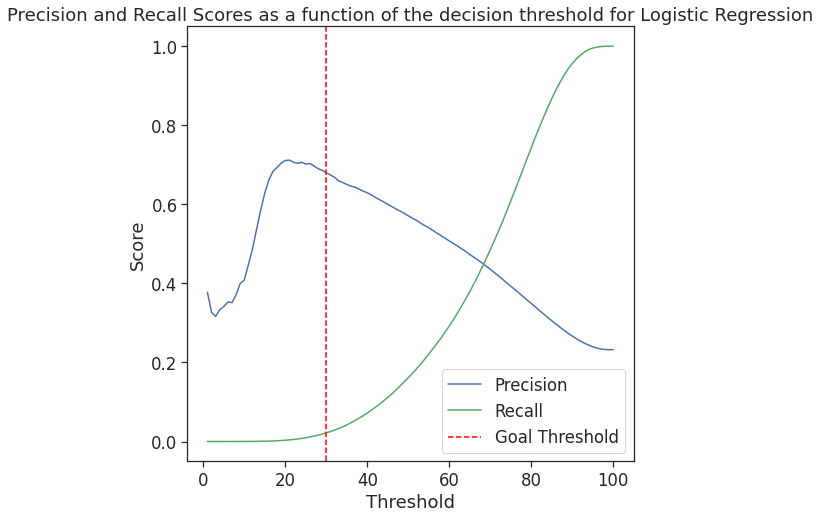

In [ ]:
# pr-k curve for Logistic Regression
prec_rec_thre(lr_model, X_train, y_train, "Logistic Regression")

In [ ]:
# check the coeffcient of logistic regression
td = train_data.drop(columns='default').columns
coef = np.exp(lr_model.coef_[0])
scaled_coef = (coef - np.min(coef))/np.ptp(coef)
lr_model_coef = pd.DataFrame(scaled_coef, td, columns=['scaled_coef']).sort_values('scaled_coef', ascending = False)
lr_model_coef.head(10)


,scaled_coef
installment,1.000000
term_ 60 months,0.751908
dti,0.423094
total_bal_ex_mort,0.415582
issue_year,0.390144
acc_open_past_24mths,0.363033
credit_line_length,0.354114
num_sats,0.339415
percent_bc_gt_75,0.330493
num_il_tl,0.324825


### 4-2. Decision Tree classifier

Since the Decision Tree hyperparameter tuning took too long to run, for the scope of this project, we only use the top 30 important features selected by the untuned RF model to fine tune a Decision Tree model. 

In [ ]:
important_features = []

for i in importances['Columns'][:30]:
    important_features.append(i)

In [ ]:
X_train = train_data[important_features]
y_train = train_data['default']
X_test = test_data[important_features]

In [ ]:
dtc = DecisionTreeClassifier(random_state=1998)

param_grid = { 
    'max_depth': [5,10,20],
    'min_samples_split': [2,5,10]
}

CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='recall')
CV_dtc.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1998),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [ ]:
CV_dtc.best_params_

{'max_depth': 20, 'min_samples_split': 2}

In [ ]:
dtc_model = DecisionTreeClassifier(max_depth=20, min_samples_split=2)
dtc_model.fit(X_train,y_train)
y_score = dtc_model.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_score)

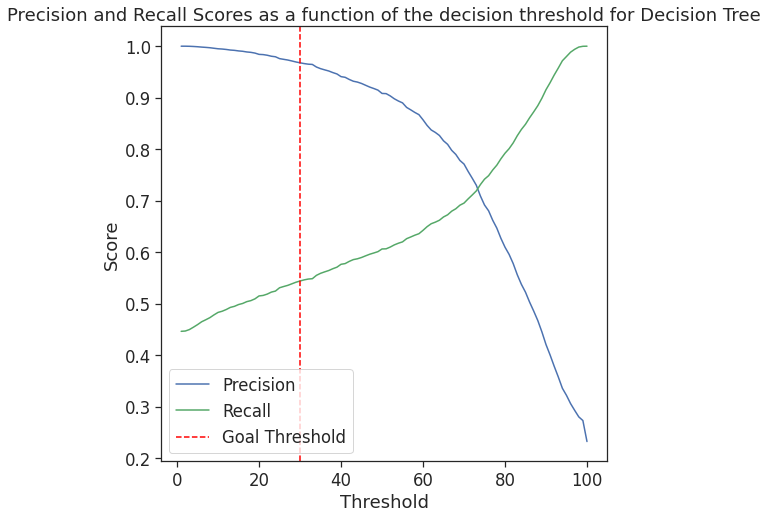

In [ ]:
# pr-k curve for Decision Tree
prec_rec_thre(dtc_model, X_train, y_train, "Decision Tree")

### 4-3. Random Forest classifier

Since the Random Forest hyperparameter tuning took too long to run, for the scope of this project, we only use the top 30 important features selected by the untuned RF model to fine tune a new RF model. 

In [ ]:
rfc = RandomForestClassifier(random_state=1998, n_jobs=-1)

param_grid = { 
    'n_estimators': [8,10,12],
    'max_depth': [9,11,13],
}


CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='recall')
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

{'max_depth': 11, 'n_estimators': 10}

In [ ]:
rfc_model = RandomForestClassifier(max_depth=11, n_estimators=10)
rfc_model.fit(X_train,y_train)
y_score = rfc_model.predict_proba(X_train)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_score)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

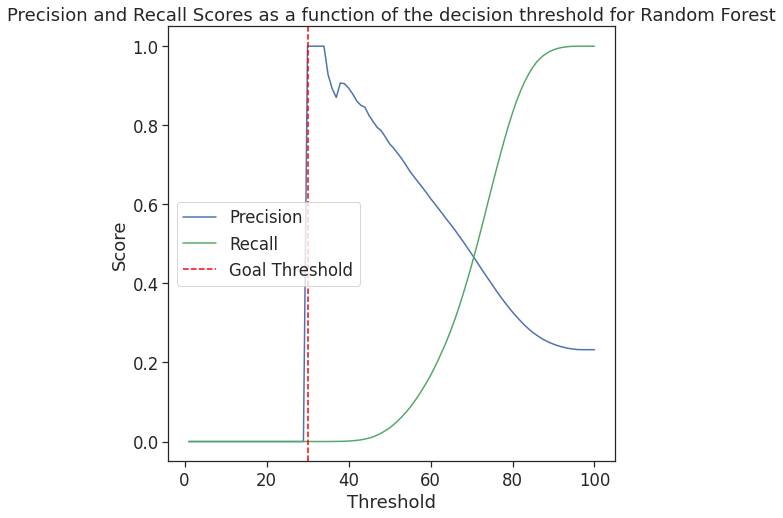

In [ ]:
# pr-k curve for Random Forest
prec_rec_thre(rfc_model, X_train, y_train, "Random Forest")

## 5. Model Evaluation

### Compare four models

In [ ]:
goal_threshold = 0.3
models = [lr_model, dtc_model, rfc_model]
recalls = []
precisions = []

for model in models:
  y_ts_score = y_hat(model, X_train, goal_threshold)
  recalls.append(recall_score(y_train, y_ts_score))
  precisions.append(precision_score(y_train,y_ts_score))

data_tuples = list(zip(models, recalls, precisions))
pd.DataFrame(data_tuples, columns=['Model', 'Recall@30%', 'Precision@30%'])


,Model,Recall@30%,Precision@30%
0,LogisticRegression(max_iter=200),0.022052,0.679856
1,DecisionTreeClassifier(max_depth=20),0.544060,0.967732
2,"(DecisionTreeClassifier(max_depth=11, max_feat...",0.000011,1.000000


### Evaluate best model (Decision Tree) on test data

In [ ]:
y_ts_score = y_hat(dtc_model, X_test, 0.3)
recall_score(y_test, y_ts_score)


0.24060314685314685

In [ ]:
precision_score(y_test, y_ts_score)

0.42406501559912185

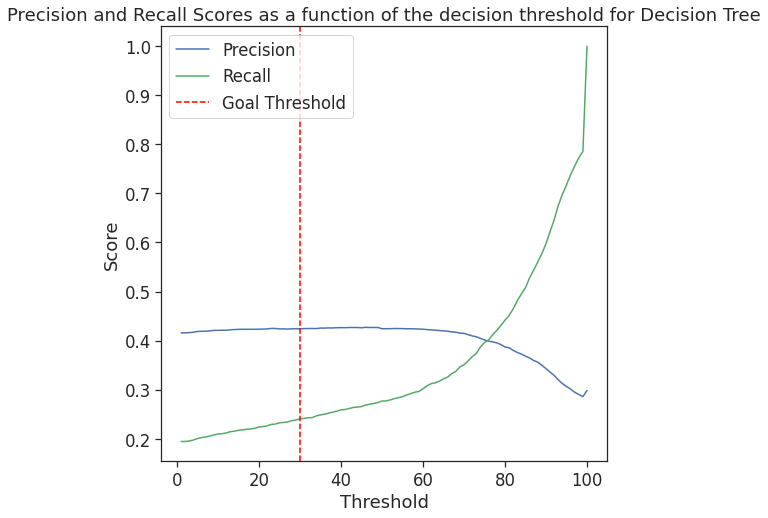

In [ ]:
prec_rec_thre(dtc_model, X_test, y_test, "Decision Tree")

### Compare the best model with base rate and baseline

- The precision at 30% of the best model is 0.42, which is much higher than the base rate, 0.24. Hence, our model is much better than random guess.
- The recall at 30% of the best model is 0.24, which is much lower than the baseline. Therefore, we would recommend LendingClub continue using its existing system. 

## 6. Future Work

- Given that our model performance is worse than the existing system, the first step will be to try more models and continue fine-tuning them.
- We chose to use the recall at 30% as the evaluation metric to select the best model. We could further incorporate model performance stability and model fairness into evaluation metrics. We can train a model on more different train-validation sets for each model type and its specific set of hyperparameters; each set is trained on different years. In this way, we could observe the model performance over time and calculate the recall variation at 30% over time. It is likely that our model will face a model bias issue. For example, the false discovery rate for low-income borrowers may be much higher than that for high-income borrowers, which would be a discrimination of disadvantageous clients. Our model selection strategy should be a trade-off among model performance, stability, and fairness in the future.